<a href="https://colab.research.google.com/github/DerManjuel/MIR/blob/Manuel/NEW_MIR_05_NLP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  <div>
    <h1 align="center">Excercise 05 - Medical Information Retrieval 2023</h1>
  </div>
  <br />

Today, we are moving on, towards a machine learning approach for text classification. 

## Text classification <a class="anchor" id="first"></a>

In the following 3 weeks we are focussing on machine learning approaches on our classification task. Feel free to use any tool which helps you, as long as you can explain, what exactelly is happening, and why it is useful. Given, that you know the preprocessing steps from the past weeks and are able to apply them, we want you to use them now in order to develop a machine learning model for our classification problem.

### Requirements
* The notebook should run **without any error**, given that all packages are installed and the dataset is loaded. When we test it, we will adapt path definitions and might will install nessesary packages)
* Your training/validation script should only use the train split we give you.

### Evaluation
* For evalutation, you can use the function "test_model_performance" in this notebook for accuracy, precision, recall and F1-score. If you choose to use such evaluation, the predicted labels have to be hot-encoded: The output of your model should be a vector of probabilities for each class. 
### Your tasks

* Make an exploratory data analysis
* Develop a preprocessing pipeline
* Train and test one or several machine learning models
* Evaluate the algorithms with a metric of your choice 
* Visualize the outcome

* Prepare a presentation (or present this notebook) of around 10 minutes for our last session (6th of June)


You can start from here. To have a comparable evaluation between each group, we give you a fixed train and test split.

In [ ]:
! git clone https://github.com/DerManjuel/MIR

In [12]:
### loading the dataset ###
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
from torch.cuda import amp
!pip install torchmetrics
import torchmetrics as metric
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
from collections import Counter
import seaborn as sns
import string
import spacy
from spacy import displacy
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Only use X and y_one_hot or y_classes for training purposes in the rest of the notebook. After running the whole notebook, there should be a prediction from your model, which took X_test as input to create the predictions. Each prediction has to be a vector of length 40.

## Data exploration
Analysing the data. Visualize most common words and medical spezialities. Remove Stop Words afterwards and tokenize/lemmatize the data.

In [15]:
# inspect data
df = pd.read_csv('MIR/Data/mtsamples_clean.csv')
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


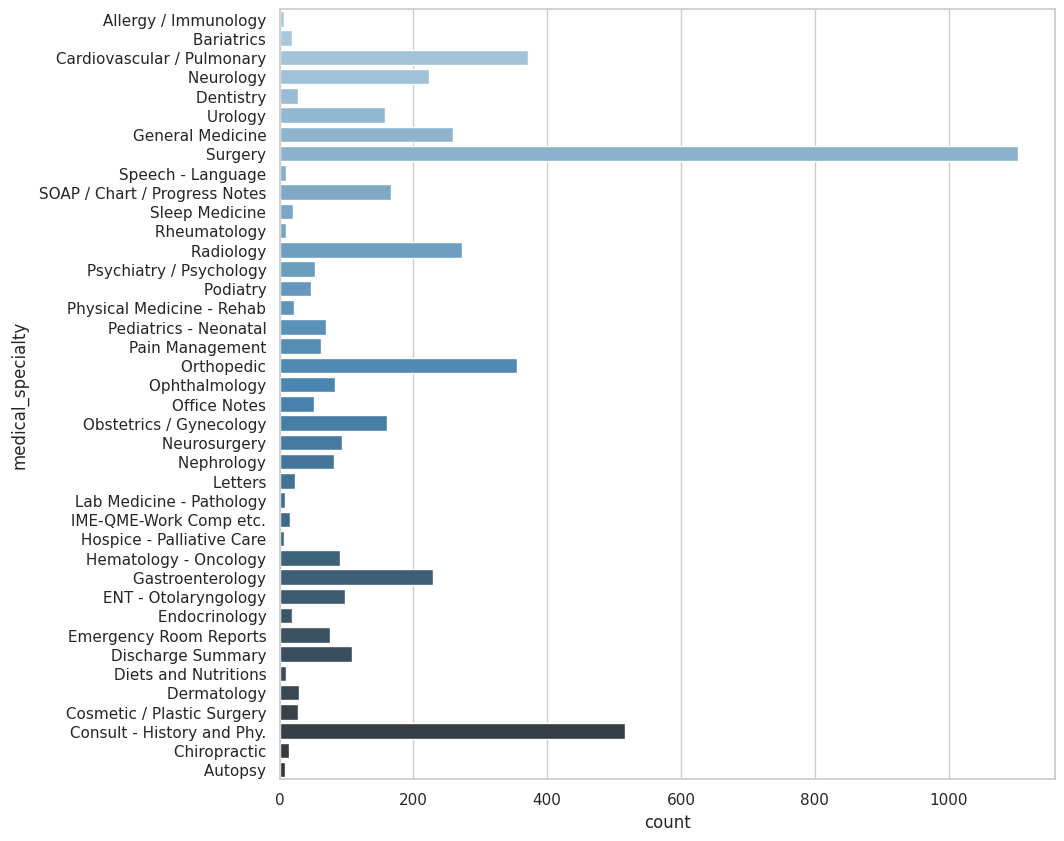

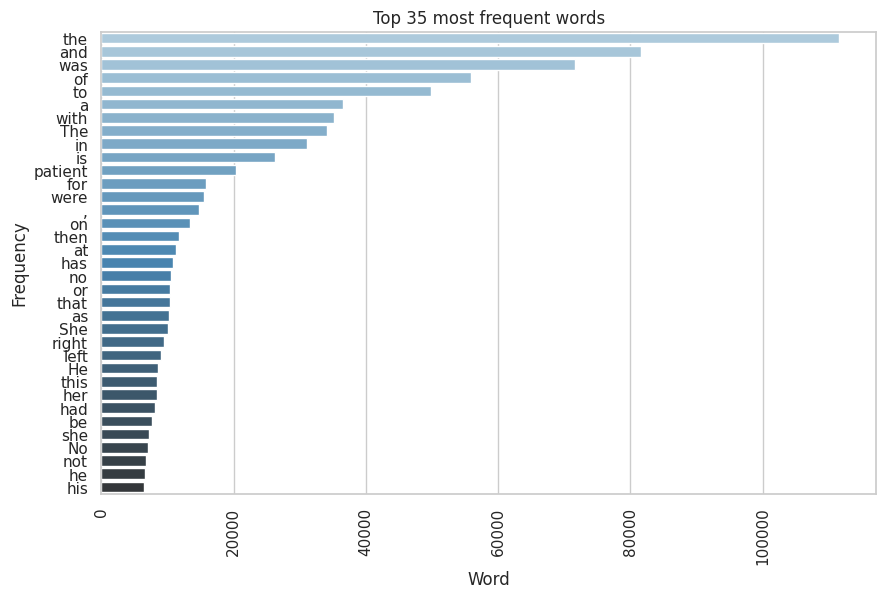

In [16]:
# visualize classes (medical spezialities)
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.countplot(y='medical_specialty', data=df, palette="Blues_d")
plt.show()

# visualize most frequent words
word_counts = Counter()

for note in df["transcription"]:
    word_counts += Counter(str(note).split())

# Visualize the top 20 most frequent words in a bar chart
# Create a dataframe of word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])
word_counts_df.index.name = "word"
word_counts_df.reset_index(inplace=True)

# Filter the top 35 most frequent words
top_words = word_counts_df.nlargest(35, "count")

# Visualize the top 35 most frequent words using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=top_words, y="word", x="count", palette="Blues_d")
plt.title("Top 35 most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

## Preprocessing

In [18]:
# 2. Clean the data (lowercase, removing all punctuation, etc.)

# remove empty rows
df = df.dropna(subset=['transcription'])

# lowercase all
df['transcription'] = df['transcription'].apply(lambda s: s.lower())

# remove punctuation
df['transcription'] = df['transcription'].apply(lambda s: re.sub(r'[^\w\s]', ' ', s))

df.head()

<ipython-input-18-7adeb4d6f019>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription'] = df['transcription'].apply(lambda s: s.lower())


,medical_specialty,transcription,cleanTranscripts
0,Allergy / Immunology,subjective this 23 year old white female pr...,subjective this 23 year old white female pr...
1,Bariatrics,past medical history he has difficulty climb...,past medical history he has difficulty climb...
2,Bariatrics,history of present illness i have seen abc ...,history of present illness i have seen abc ...
3,Cardiovascular / Pulmonary,2 d m mode 1 left atrial enlargement wit...,2 d m mode 1 left atrial enlargement wit...
4,Cardiovascular / Pulmonary,1 the left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall ...


In [19]:
from collections import Counter
from tabulate import tabulate

def unique_words_counter(df):
    # utils function to count unique words in our corpus
    word_counts = Counter()
    for s in df['transcription']:
        word_counts.update(s.split())
    return word_counts

# 3. Stop word removal

# lets look at the most common words in our corpus

word_counts = unique_words_counter(df)

# print most common words
print(tabulate(word_counts.most_common(16), headers=['Word', 'Count']))


# those are mostly stop words, lets remove them 
# but first, lets count all words in the corpus and see how many unique words there are before stop word removal

print(f'There are {len(word_counts)} unique words in our corpus before stop word removal')


# lets remove stop words

from nltk.corpus import stopwords

stop_words = stopwords.words('english')

df['transcription'] = df['transcription'].apply(lambda s: ' '.join([word for word in s.split() if word not in stop_words]))

print(f'There are {len(unique_words_counter(df))} unique words in our corpus after stop word removal')

Word       Count
-------  -------
the       149888
and        82779
was        71765
of         59205
to         50632
a          43031
with       35815
in         32808
is         26378
patient    24208
no         17874
she        17593
for        17049
he         15544
were       15535
on         14694
There are 22498 unique words in our corpus before stop word removal
There are 22361 unique words in our corpus after stop word removal


In [20]:
# 3. Stemming/Lemmatization

print(f'There are {len(unique_words_counter(df))} unique words in our corpus before stemming')

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

df['transcription'] = df['transcription'].apply(lambda s: ' '.join([stemmer.stem(word) for word in s.split()]))

# lets count all words in the corpus and see how many unique words there are after stemming

word_counts = Counter()

for s in df['transcription']:
    word_counts.update(s.split())

print(f'There are {len(word_counts)} unique words in the corpus after stemming')

There are 22361 unique words in our corpus before stemming
There are 15994 unique words in the corpus after stemming


In [21]:
print(tabulate(word_counts.most_common(16), headers=['Word', 'Count']))

Word        Count
--------  -------
patient     24275
right       11587
left        11258
2           10136
1            9842
histori      9514
use          9129
place        8369
procedur     8100
normal       7680
3            7228
0            7172
well         6643
5            6614
pain         6297
4            6263


In [22]:
# data-cleaner class

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm import tqdm

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        print('Lowercasing')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = X[i].lower()

        
        print('Removing punctuation')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = re.sub(r'[^\w\s]', ' ', X[i])
        
        return X
    
# stop-word-remover class

class StopWordRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('Removing stop words')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([word for word in X[i].split() if word not in stop_words])
        
        return X
    
# stemmer class

class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # stem words
        print('Stemming')
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([stemmer.stem(word) for word in X[i].split()])
        
        return X
    
# lemmatizer class

nltk.download('wordnet')
nltk.download('omw-1.4')

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # lemmatize words
        print('Lemmatizing')
        lemmatizer = WordNetLemmatizer()
        for i in tqdm(range(len(X)), total=len(X)):
            X[i] = ' '.join([lemmatizer.lemmatize(word) for word in X[i].split()])
        
        return X

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


**Vectorization**

Create train and test split and create a model for the classification task.

In [24]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('stop_word_remover', StopWordRemover()),
    ('stemmer', Stemmer()),
    ('lemmatizer', Lemmatizer()),
])


In [25]:
def apply_preprocessing(pipeline=None):
    df = pd.read_csv('MIR/Data/mtsamples_clean.csv')
    df = df.dropna(subset=['transcription'])

    if pipeline is not None:
        X = df['transcription'].values
        X = pipeline.transform(X)
        df['transcription'] = X

    return df

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizerSklearn

def train(df, net, savename="plot.png"):
    CONTEXT_SIZE = 2
    EMBEDDING_DIM = 100

    losses = []
    loss_function = nn.NLLLoss()
    model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # creating train and test split    
    _X, _y = df['transcription'].values, df['medical_specialty'].values
    _y_one_hot = pd.get_dummies(_y)

    X, X_test, y_one_hot, _ = train_test_split(_X, _y_one_hot, test_size=0.2, random_state=123)
    _, _, y_classes, _ = train_test_split(_X, _y, test_size=0.2, random_state=123)
    #X_train, X_test, y_train, y_test = train_test_split(df['transcription'].values, df['medical_specialty'].values, test_size=0.2, random_state=42)
    vocab = set(X)
    # Define the text classification pipeline
    text_clf = Pipeline([
        ('vect', CountVectorizerSklearn(lowercase=False, tokenizer=WhitespaceTokenizer().tokenize)), # use the custom tokenizer
        ('clf', MultinomialNB())
    ])

    for epoch in range(10):
        total_loss = 0
        for context, target in trigrams:
            context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
            model.zero_grad()
            log_probs = model(context_idxs)
            loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
    print(losses)

    """# Train the pipeline on the preprocessed data
    text_clf.fit(X, y_one_hot)

    predicted = text_clf.predict(X_test)

    # Classification report
    report = classification_report(y_test, predicted, output_dict=True)

    # change figsize
    plt.figure(figsize=(20, 10))
    report_df = pd.DataFrame(report).iloc[:-1, :].T

    sns.heatmap(pd.DataFrame(report_df), annot=True)

    plt.savefig(savename, bbox_inches='tight', transparent=False)
    """

In [ ]:
def test_model_performance(y_pred):
    #_, _, _, y_test = train_test_split(_X, _y_one_hot, test_size=0.2, random_state=123)

    # set highest to 1 and rest to 0
    #y_pred = np.argmax(y_pred, axis=1)

    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [28]:
class NGramLanguageModeler(nn.Module):

  def __init__(self, vocab_size, embedding_dim, context_size):
          super(NGramLanguageModeler, self).__init__()
          self.embeddings = nn.Embedding(vocab_size, embedding_dim)
          self.linear1 = nn.Linear(context_size * embedding_dim, 128)
          self.linear2 = nn.Linear(128, vocab_size)
          
  def forward(self, inputs):
          embeds = self.embeddings(inputs).view((1, -1))
          out = F.relu(self.linear1(embeds))
          out = self.linear2(out)
          log_probs = F.log_softmax(out, dim=1)
          return log_probs

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predic

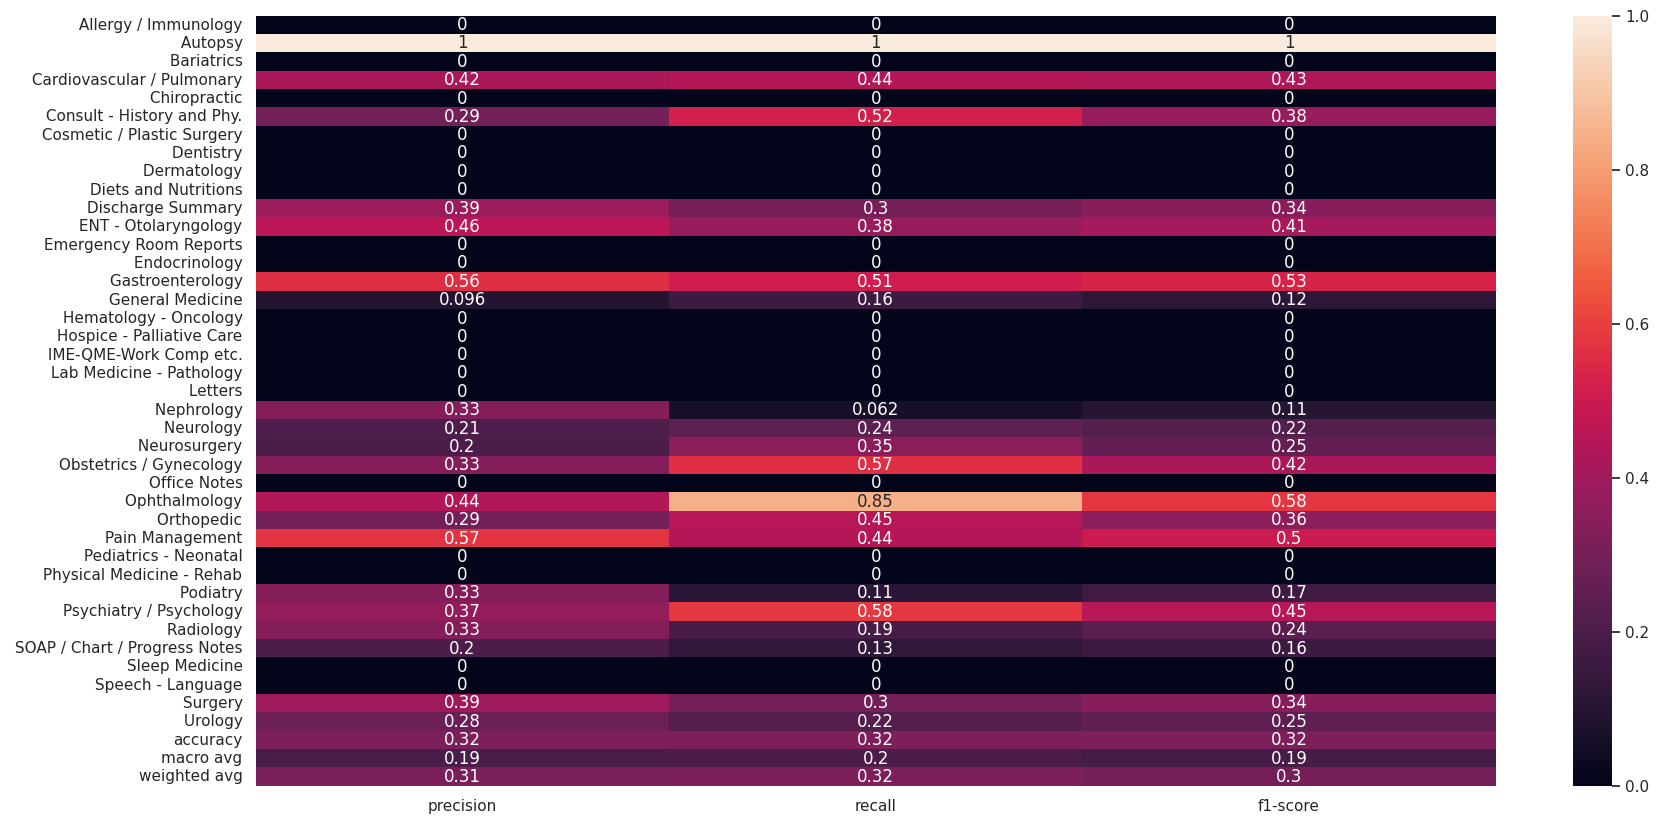

In [27]:
train(df, savename='some_name')

## Model